In [3]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. We want to be able to marginalise out product and price to see effect of shelf position (`product_index`). As there is a binary input put from the user, the model will have to be based on the logisitic model:

$$ \mathrm{logit}[\mathrm{p}(y_{ij}=1|,\alpha_{i},\beta_{i},\gamma_{i})] = f(\alpha_{i},\beta_i,\gamma_{i})  $$

* $y_{ij}$ is the response for person $j$ to a particular product ($\alpha_{i}$) at a particular price ($\beta_{i}$)   and location on shelf ($\gamma_{i}$) i.e. `fit`=1 or `does not fit`=0
* $\alpha_{i} $ is product (discrete)
* $\beta_i$ is price (continuous)
* $\gamma_{i}$ is position (discrete)

The key is coming up with the function ($f$)

For our second model, we will still assume a linear relationship between price and product placement:
$$m*\beta_{i}+c_{\gamma_{i}}$$
where:
* $m$ is slope, telling us how much price affects selection
* $c$ is intercept, telling us how much product position changes selection

However, we will now introduce a hierarchical element to the intercept, such that there is a global mean intercept for all positions. At first, I will treat this as independent, but is should really by a multi D Gaussian.

## Build the model

In [8]:
model="""
data {
  int<lower=1> K;              // number of product places
  int<lower=1> N;              // number of observations
  vector[N] price;  //product price for observation n
  int<lower=1,upper=K> kk[N];  // product place for observation n
  int<lower=0,upper=1> y[N];   // selected or not for observation n
  int<lower=0> nprice; //number of price points
  vector[nprice] price_pred; //price points for predictions
  int<lower=1> P; //number of products
  int<lower=1> product[N]; //product for observation n
}

parameters {
  vector[K] c_raw[P];              // effect of place for k
  real m[P]; // slope;
  vector[K] hier_c_mean; 
  vector<lower=0.001>[K] hier_c_sig;
}

transformed parameters {
vector[K] c[P];
for (i in 1:P){
for (j in 1:K){
c[i,j]=hier_c_mean[j] +hier_c_sig[j]*c_raw[i,j];
}
}
}

model {
for (i in 1:P){
m[i] ~ std_normal();
c_raw[i] ~std_normal();
}
hier_c_mean~std_normal();
hier_c_sig~std_normal();
  
  if (N > 1){
  for (i in 1:N){
  y[i] ~ bernoulli_logit(m[product[i]]*price[i] + c[product[i],kk[i]]);
  }
  }
}

generated quantities {
vector[N] y_rep;
matrix[nprice,K] pred_matrix[P];
matrix[nprice,K] pred_matrix_select[P];
if (N<)
for (i in 1:nprice){
for (j in 1:K){
for (z in 1:P){
pred_matrix[z,i,j]=m[z]*price_pred[i] + c[z,j];
pred_matrix_select[z,i,j]=bernoulli_logit_rng(pred_matrix[z,i,j]);
}
}
}
if (N > 1){
for (i in 1:N){
y_rep[i] = bernoulli_logit_rng(m[product[i]]*price[i] + c[product[i],kk[i]]);
}
}
}
"""

In [9]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_13ca4d6fba16672d93427f44eb46a163 NOW.


In [10]:
data={
    'K':5,
    'N':1,
    'price':[0],
    'kk':[1],
    'y':[1],
    'nprice':10,
    'price_pred':np.arange(-5,5,1.0),
    'P':8,
    'product':[1]
}

In [11]:
fit=sm.sampling(data=data,chains=1,iter=500)

In [12]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_13ca4d6fba16672d93427f44eb46a163.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_raw[1,1]      -0.01    0.04    1.0  -2.24  -0.63   0.01    0.6   1.98    775    1.0
c_raw[2,1]       0.05    0.04   1.03  -1.83  -0.73   0.06   0.81   2.02    641    1.0
c_raw[3,1]      -0.01    0.05   0.98  -2.02  -0.66  -0.04   0.65   1.78    417    1.0
c_raw[4,1]       0.03    0.05   0.94  -1.82  -0.65-6.3e-3   0.68   1.99    436    1.0
c_raw[5,1]      -0.03    0.04   1.01  -2.05   -0.7   0.03   0.63   1.93    676    1.0
c_raw[6,1]      -0.05    0.03   0.97  -1.78  -0.82  -0.08   0.71   1.73    771    1.0
c_raw[7,1]       0.05    0.04   0.99  -2.01  -0.65   0.06   0.76   1.97    488    1.0
c_raw[8,1]       0.02    0.05   1.02  -1.94  -0.67   0.08   0.62   2.05    449    1.0
c

<Figure size 720x720 with 0 Axes>

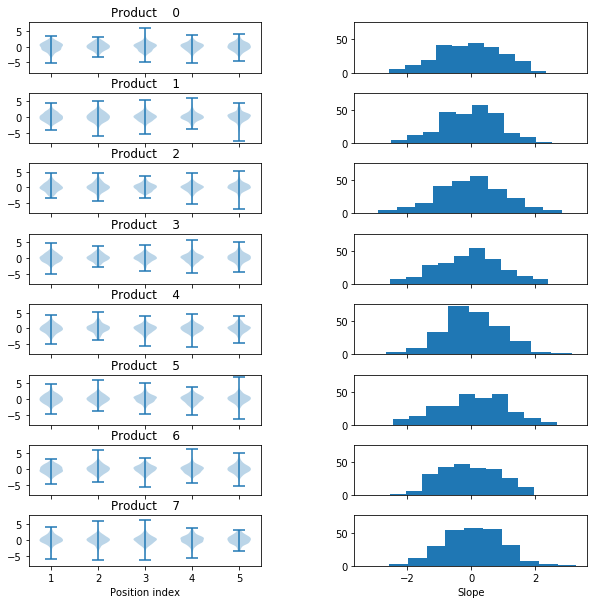

In [13]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(fit.data['P'], 2, sharex='col', sharey='col',figsize=(10,10))
for i in range(0,fit.data['P']):
    ax[i,0].violinplot(fit['c'][:,i,:]);
    ax[i,1].hist(fit['m'][:,i]);
    ax[i,0].set_title('Product {:4.0f}'.format(i))
ax[-1,0].set_xlabel('Position index')
ax[-1,1].set_xlabel('Slope')
fig.subplots_adjust(hspace=0.4, wspace=0.4)


The intercept and slopes for the different products

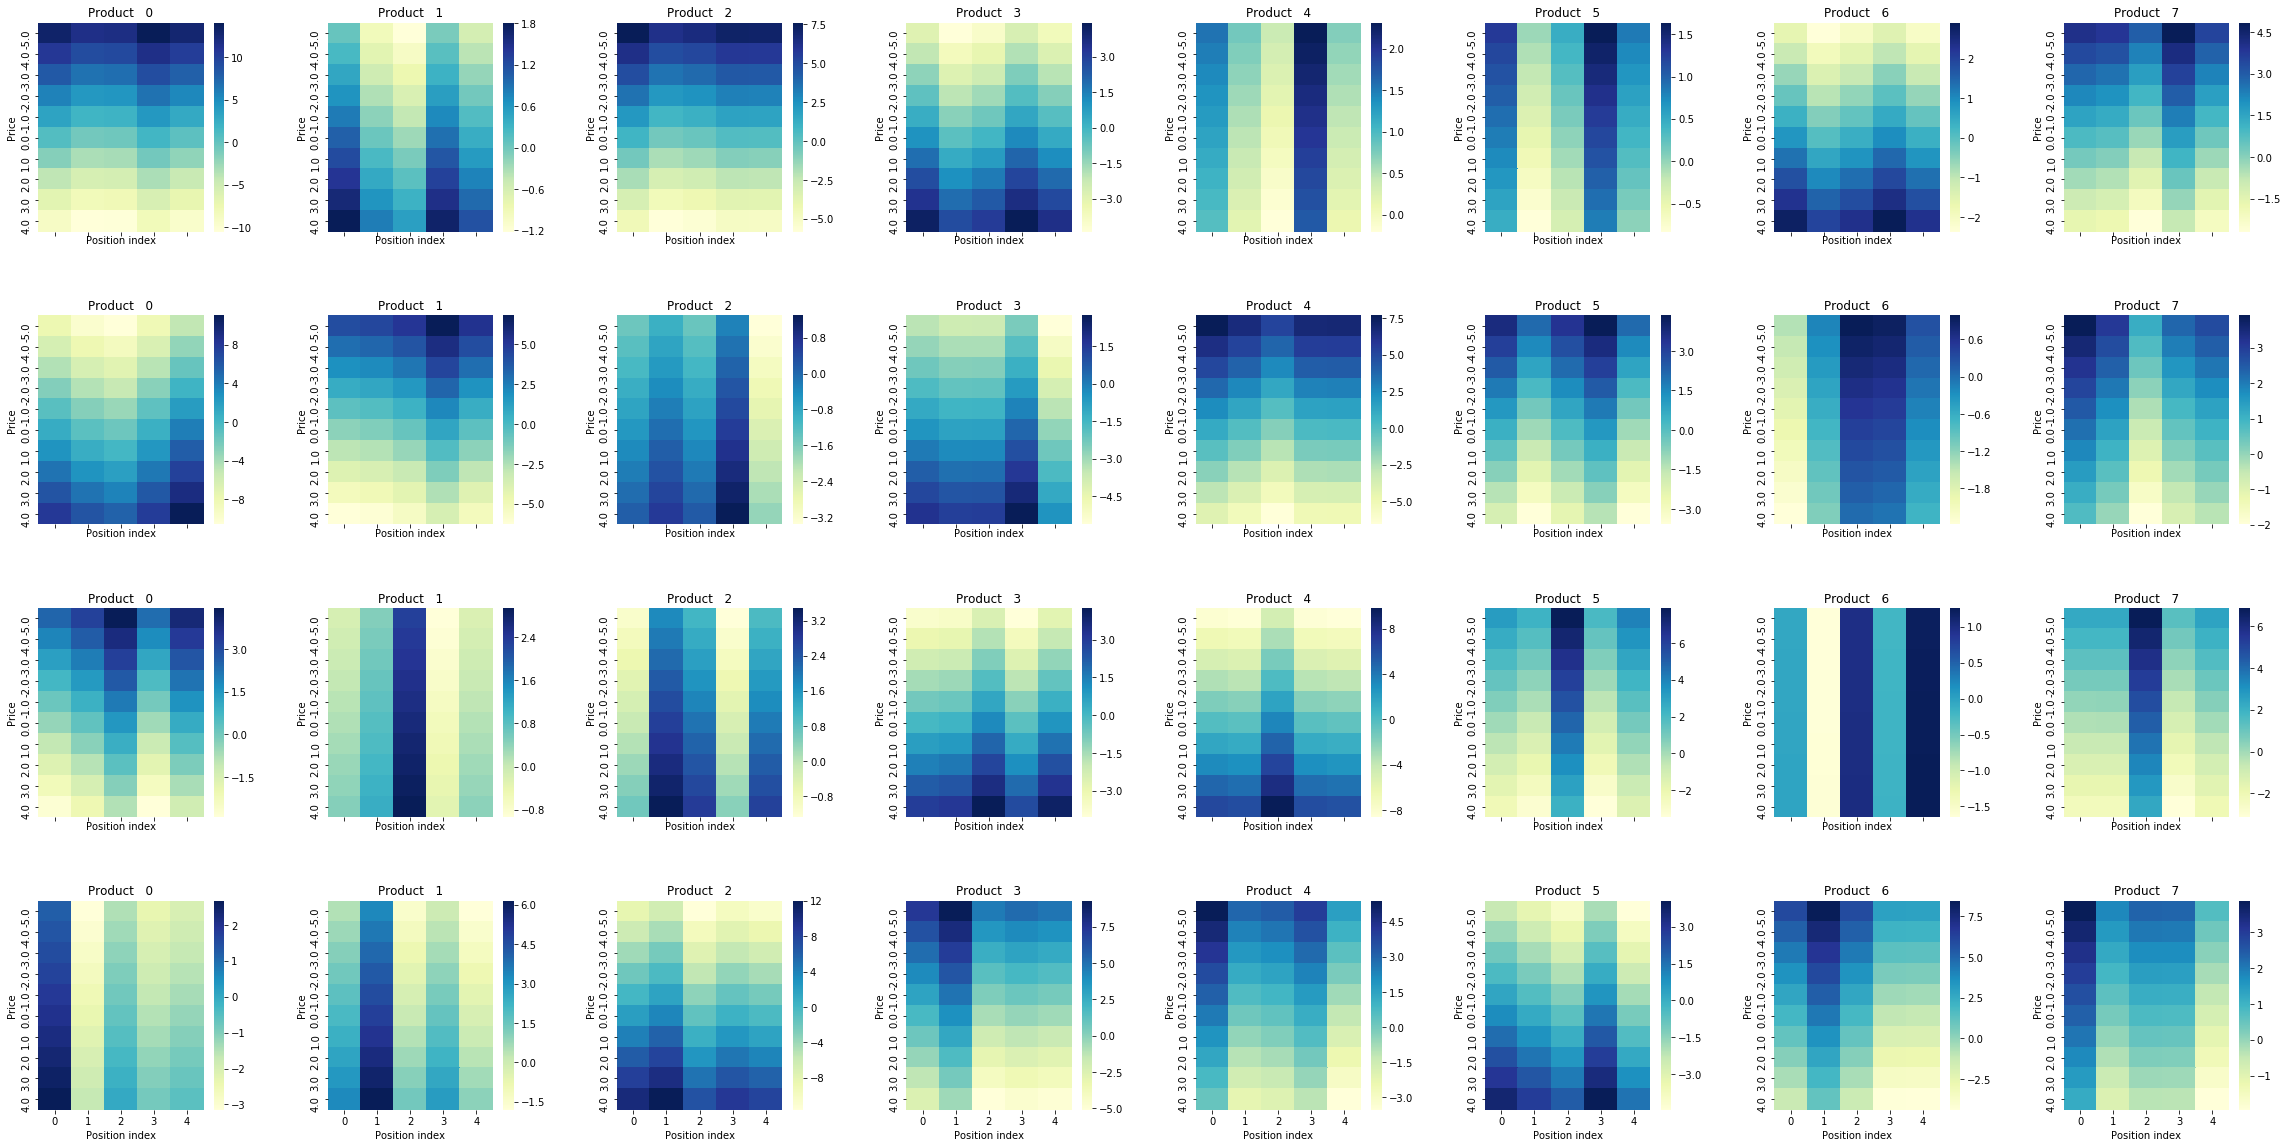

In [14]:
s=[0,1,2,10]
fig, ax = plt.subplots(len(s), fit.data['P'], sharex='col', sharey='col',figsize=(40,20))

for i in range(0,len(s)):
    for p in range(0,fit.data['P']):
        sns.heatmap(fit['pred_matrix'][s[i],p,:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,p],)
        ax[i,p].set_xlabel('Position index')
        ax[i,p].set_ylabel('Price')
        ax[i,p].set_title(r'Product{:4.0f}'.format(p))
    #sns.heatmap(fit['pred_matrix_select'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,1])

fig.subplots_adjust(hspace=0.4, wspace=0.4)


A plot showing the different prediction matrices for different products in each row. Each row is a different sample from the prior. Note how there is a similar effect from certian positions in each row. This is coming from the hierarchical prior.

Text(0.5, 0, 'positions')

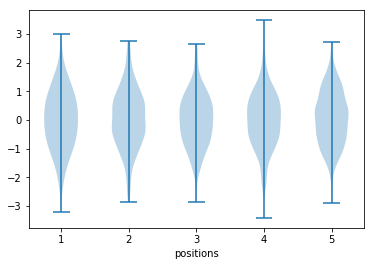

In [15]:
plt.violinplot(fit['hier_c_mean'])
plt.xlabel('positions')

The hierarchical mean values for position

## Fit prior samples

In [16]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))

In [17]:
def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind>0

In [18]:
zscore_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
zscore_prior_pred_m=np.empty((fit.data['P'],10))
shrinkage_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
shrinkage_prior_pred_m=np.empty((fit.data['P'],10))
zscore_hier_mean=np.empty((fit.data['K'],10))
zscore_hier_sig=np.empty((fit.data['K'],10))
shrinkage_hier_mean=np.empty((fit.data['K'],10))
shrinkage_hier_sig=np.empty((fit.data['K'],10))


for s in range(0,10):
    data_prior={
        'K':fit.data['K'],
        'N':fit['pred_matrix'][s,:,:,:].flatten().size,
        'price':np.tile(np.repeat(np.arange(-5,5,1.0),fit.data['K']),fit.data['P']),
        'kk':np.tile(np.tile(np.arange(1,6,1),10),fit.data['P']),
        'y':fit['pred_matrix_select'][s,:,:].flatten().astype(int),
        'nprice':10,
        'price_pred':np.arange(-5,5,1.0),
        'P':8,
        'product':np.repeat(np.arange(1,fit.data['P']+1),fit.data['K']*fit.data['nprice'])
        }
    fit_prior=sm.sampling(data=data_prior)
    zscore_prior_pred_c[:,:,s]=zscore(fit_prior['c'],fit['c'][s,:,:])
    for j in range(0,fit.data['P']):
        shrinkage_prior_pred_m[j,s]=shrinkage(fit_prior['m'][:,j],fit['m'][:,j])
        for i in range(0,fit.data['K']):
            shrinkage_prior_pred_c[j,i,s]=shrinkage(fit_prior['c'][:,j,i],fit['c'][:,j,i])
    zscore_prior_pred_m[:,s]=zscore(fit_prior['m'],fit['m'][s])
    zscore_hier_mean[:,s]=zscore(fit_prior['hier_c_mean'],fit['hier_c_mean'][s])
    zscore_hier_sig[:,s]=zscore(fit_prior['hier_c_sig'],fit['hier_c_sig'][s])
    for i in range(0,fit.data['K']):
        shrinkage_hier_mean[i,s]=shrinkage(fit_prior['hier_c_mean'][:,i],fit['hier_c_mean'][:,i])
        shrinkage_hier_sig[i,s]=shrinkage(fit_prior['hier_c_sig'][:,i],fit['hier_c_sig'][:,i])

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


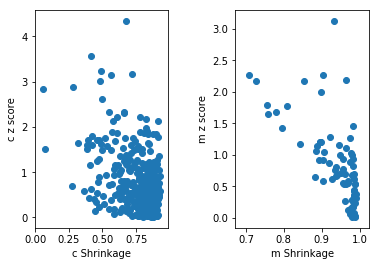

In [19]:
plt.subplot(1,2,1)
plt.scatter(shrinkage_prior_pred_c,zscore_prior_pred_c)
plt.xlabel('c Shrinkage')
plt.ylabel('c z score')
plt.subplot(1,2,2)

plt.scatter(shrinkage_prior_pred_m,zscore_prior_pred_m)
plt.xlabel('m Shrinkage')
plt.ylabel('m z score')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

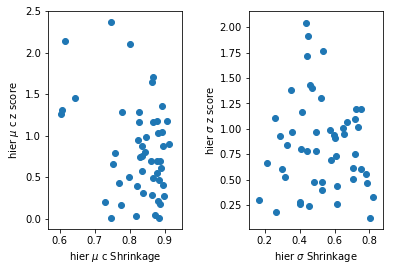

In [20]:
plt.subplot(1,2,1)
plt.scatter(shrinkage_hier_mean,zscore_hier_mean)
plt.xlabel('hier $\mu$ c Shrinkage')
plt.ylabel('hier $\mu$ c z score')
plt.subplot(1,2,2)

plt.scatter(shrinkage_hier_sig,zscore_hier_sig)
plt.xlabel('hier $\sigma$ Shrinkage')
plt.ylabel('hier $\sigma$ z score')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

# Fit model to data
At the moment the model is built for one person and one product. We could assume everyone acts the same as a first pass and fit for every object.

In [50]:
data=pd.read_csv('../../../data/raw/priced_shelves_data.csv')
data['id.session_int']=data.groupby('id.session').grouper.group_info[0]+1
data['selected_int']=data.groupby('selected').grouper.group_info[0]
data['product_int']=data.groupby('product').grouper.group_info[0]+1
data['mean_sub_price']=data['price']-data.groupby('product').transform('mean')['price']


In [85]:
ind=data['product_int']<10

In [73]:
data_infer={
    'K':data['product_index'].unique().size,
    'N':len(data[ind]),
    'price':data[ind]['mean_sub_price'],
    'kk':data[ind]['product_index'].values+1,
    'y':data[ind]['selected_int'],
    'nprice':9,
    'price_pred':np.arange(8,17,1.0),
    'P':data[ind]['product_int'].unique().size,
    'product':data[ind]['product_int']
    }


In [74]:
fit_infer=sm.sampling(data=data_infer,chains=1,iter=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [75]:
pystan.check_hmc_diagnostics(fit_infer)

{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [76]:
fit_infer


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_13ca4d6fba16672d93427f44eb46a163.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_raw[1,1]      5.8e-3    0.06   0.94  -1.87  -0.66   0.03   0.63   1.79    235   1.01
c_raw[2,1]       -0.09    0.07   1.01  -2.16  -0.71  -0.06    0.6   1.87    222    1.0
c_raw[3,1]       -0.08    0.06   1.01  -1.92  -0.82  -0.14   0.49    2.2    298    1.0
c_raw[4,1]        0.04    0.04   0.96   -1.8  -0.52   0.04   0.66   1.98    452    1.0
c_raw[1,2]        0.04    0.07   1.01  -1.83  -0.75   0.03   0.69   2.11    218    1.0
c_raw[2,2]       -0.05    0.05   0.84  -1.73  -0.52  -0.03   0.48   1.56    238    1.0
c_raw[3,2]       -1.26    0.05   0.63  -2.48  -1.67  -1.28  -0.91   0.24    175    1.0
c_raw[4,2]        0.05    0.05   1.01  -1.97  -0.69  -0.02    0.7    2.1    415

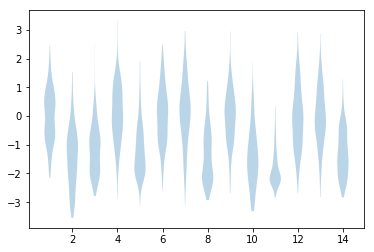

In [77]:
plt.violinplot(fit_infer['hier_c_mean'],showextrema=False);